Classification problem using several ML models, comparing them and hyperparameter tune the best.

# Read and clean data

In [1]:
# Reading the column names from the file
text_file = open('Column_info.txt', 'r')
lines = text_file.readlines()
columns = [l.split(':')[0] for l in lines]
columns.append('income')


In [2]:
import pandas as pd

raw_df = pd.read_csv('adult.csv', header=None)
raw_df.columns = columns
raw_df.info()
raw_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Visualize No. of unique values on each categorical column

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


          feature  nunique
0       workclass        9
1       education       16
2  marital-status        7
3      occupation       15
4    relationship        6
5            race        5
6             sex        2
7  native-country       42
8          income        2


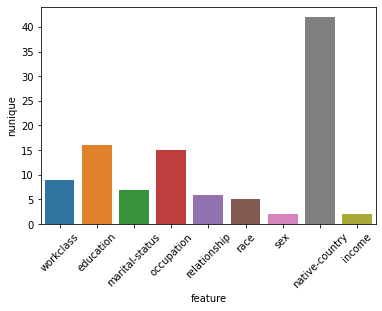

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical = raw_df.select_dtypes(include='object')
cat_unique = categorical.nunique()
cat_unique = cat_unique.reset_index()
cat_unique.columns = ['feature','nunique']
ax = sns.barplot(x='feature', y='nunique', data=cat_unique)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
print(cat_unique)

Cleaning categorical values

In [4]:
# Printing unique Values on each column 
for c in categorical:
  print(f'{c}:\n{categorical[c].value_counts()}\n')

workclass:
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

education:
 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64

marital-status:
 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64

occupation:
 Prof-specialty  

In [5]:
# Replace question mark symbol
print(any(categorical.isin([' ?']).any()))
categorical = categorical.replace(to_replace =" ?", value ="Other")
print(any(categorical.isin([' ?']).any()))

True
False


Clean Numerical Values

In [6]:
import numpy as np

# Observe info on each column
numerical = raw_df.select_dtypes(exclude='object')
print(round(numerical.describe(),2))

# Check if all values are real numbers
numerical.applymap(np.isreal).all(0)

            age      fnlwgt  ...  capital-loss  hours-per-week
count  32561.00    32561.00  ...      32561.00        32561.00
mean      38.58   189778.37  ...         87.30           40.44
std       13.64   105549.98  ...        402.96           12.35
min       17.00    12285.00  ...          0.00            1.00
25%       28.00   117827.00  ...          0.00           40.00
50%       37.00   178356.00  ...          0.00           40.00
75%       48.00   237051.00  ...          0.00           45.00
max       90.00  1484705.00  ...       4356.00           99.00

[8 rows x 6 columns]


age               True
fnlwgt            True
education-num     True
capital-gain      True
capital-loss      True
hours-per-week    True
dtype: bool

Nothing to clean

# Create a new DataFrame with the processed data

In [7]:
df = pd.concat([categorical, numerical], axis = 1)
# Rearrenge columns as raw df
df = df[raw_df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Prepare training and test data

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn import preprocessing


# Separate values into Inputs and outputs
X = df.iloc[:,df.columns != 'income']
y = df.iloc[:,df.columns == 'income']

# OneHot Encoding categorical Values in X
categorical = X.select_dtypes(include='object')
enc = OneHotEncoder()
categorical = pd.DataFrame(enc.fit_transform(categorical).toarray())

# Normalizing Numerical columns
numerical = X.select_dtypes(exclude='object')
numerical = pd.DataFrame(normalize(numerical), columns=numerical.columns)

# Label encoding y
le = preprocessing.LabelEncoder()
y = le.fit_transform(y.values.ravel())

# New inputs with preprocessed data 
print(f'categorical shape: {categorical.shape}')
print(f'numerical shape: {numerical.shape}')
X = pd.concat([categorical, numerical], axis =1)
print(f'Shape of input data: {X.shape}')

categorical shape: (32561, 102)
numerical shape: (32561, 6)
Shape of input data: (32561, 108)


Separate Training and Testing Sets

In [9]:
from sklearn.model_selection import train_test_split

# Separate into traning and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=1)
print(f'Train: {X_train.shape}, {y_train.shape}')
print(f'Test: {X_test.shape}, {y_test.shape}')

Train: (26048, 108), (26048,)
Test: (6513, 108), (6513,)


# Verify for Class Imbalances and fix it.

y_train 0: 19694
y_train 1: 6354


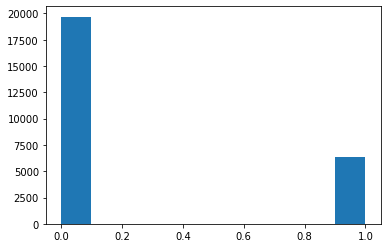

In [10]:
plt.hist(y_train)

unique, counts = np.unique(y_train, return_counts=True)
print(f'y_train {unique[0]}: {counts[0]}')
print(f'y_train {unique[1]}: {counts[1]}')
plt.show()

In [13]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
columns = X_train.columns
X_train, y_train=os.fit_sample(X_train, y_train)
X_train = pd.DataFrame(data=X_train, columns=columns )
y_train= pd.DataFrame(data=y_train, columns=['income'])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
unique, counts = np.unique(y_train, return_counts=True)
print(f'Train: {X_train.shape}, {y_train.shape}')
print(f'y_train {unique[0]}: {counts[0]}')
print(f'y_train {unique[1]}: {counts[1]}')

Train: (39388, 108), (39388, 1)
y_train 0: 19694
y_train 1: 19694


In [15]:
y_train

,income
0,0
1,1
2,1
3,0
4,0
...,...
39383,1
39384,1
39385,1
39386,1


# Build different Models and train with the data


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB



models = dict()
models['lr'] = LogisticRegression()
models['knn'] = KNeighborsClassifier()
models['cart'] = DecisionTreeClassifier()
models['svm'] = SVC()
models['bayes'] = GaussianNB()

In [17]:
# evaluate the models and store results
models['lr'].fit(X_train, y_train)
models['knn'].fit(X_train, y_train)
models['cart'].fit(X_train, y_train)
models['svm'].fit(X_train, y_train)
models['bayes'].fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

GaussianNB(priors=None, var_smoothing=1e-09)

In [18]:
predictions  = dict()
predictions['lr'] = models['lr'].predict(X_test)
predictions['knn'] = models['knn'].predict(X_test)
predictions['cart'] = models['cart'].predict(X_test)
predictions['svm'] = models['svm'].predict(X_test)
predictions['bayes'] = models['bayes'].predict(X_test)


In [19]:
list_models = ['lr', 'knn', 'cart', 'svm', 'bayes']

for l in list_models:
  print(f'Accuracy of {l}: {round(models[l].score(X_test, y_test),2)}')

Accuracy of lr: 0.79
Accuracy of knn: 0.75
Accuracy of cart: 0.79
Accuracy of svm: 0.78
Accuracy of bayes: 0.53


In [21]:
from sklearn.metrics import classification_report

reports = []
for l in list_models:
  classification = classification_report(y_test, predictions[l])
  reports.append(classification)
  print(classification)



              precision    recall  f1-score   support

           0       0.94      0.77      0.85      5026
           1       0.52      0.84      0.64      1487

    accuracy                           0.79      6513
   macro avg       0.73      0.81      0.75      6513
weighted avg       0.85      0.79      0.80      6513

              precision    recall  f1-score   support

           0       0.92      0.75      0.82      5026
           1       0.48      0.78      0.59      1487

    accuracy                           0.75      6513
   macro avg       0.70      0.76      0.71      6513
weighted avg       0.82      0.75      0.77      6513

              precision    recall  f1-score   support

           0       0.89      0.82      0.86      5026
           1       0.53      0.67      0.59      1487

    accuracy                           0.79      6513
   macro avg       0.71      0.74      0.72      6513
weighted avg       0.81      0.79      0.80      6513

              preci

Best model is Logistic Regression

# HiperParameter Tuning

https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

In [30]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# set the model selected previously
model = models['lr']
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)

# summarize results
print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'{mean} {stdev} with: {param}')


Best: 0.844866 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.844866 (0.004680) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.843924 (0.004984) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.844773 (0.004692) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.843709 (0.004436) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.843514 (0.004619) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.843698 (0.004427) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.839952 (0.004572) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.840044 (0.004691) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.840023 (0.004538) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.834772 (0.004834) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.834772 (0.004834) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.835017 (0.004939) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.829151 (0.004156) wit